In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import datasets

In [2]:
df = pd.read_csv('../input/telecom_churn.csv')
df

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,No,Yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,No,No,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,No,No,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,Yes,No,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [3]:
#ситуация такая, State, International plan, Voice mail plan - object, Churn - категория.
#Преобразить их проще всего (и короче) через LabelEncoder

In [4]:
non_numeric_features = ['State', 'International plan', 'Voice mail plan', 'Churn']

for feature in non_numeric_features:        
     df[feature] = LabelEncoder().fit_transform(df[feature])

In [5]:
#в итоге все преобразовалось в числовой тип, проблем больше не будет
#df

Text(0.5, 1.0, 'Корреляции')

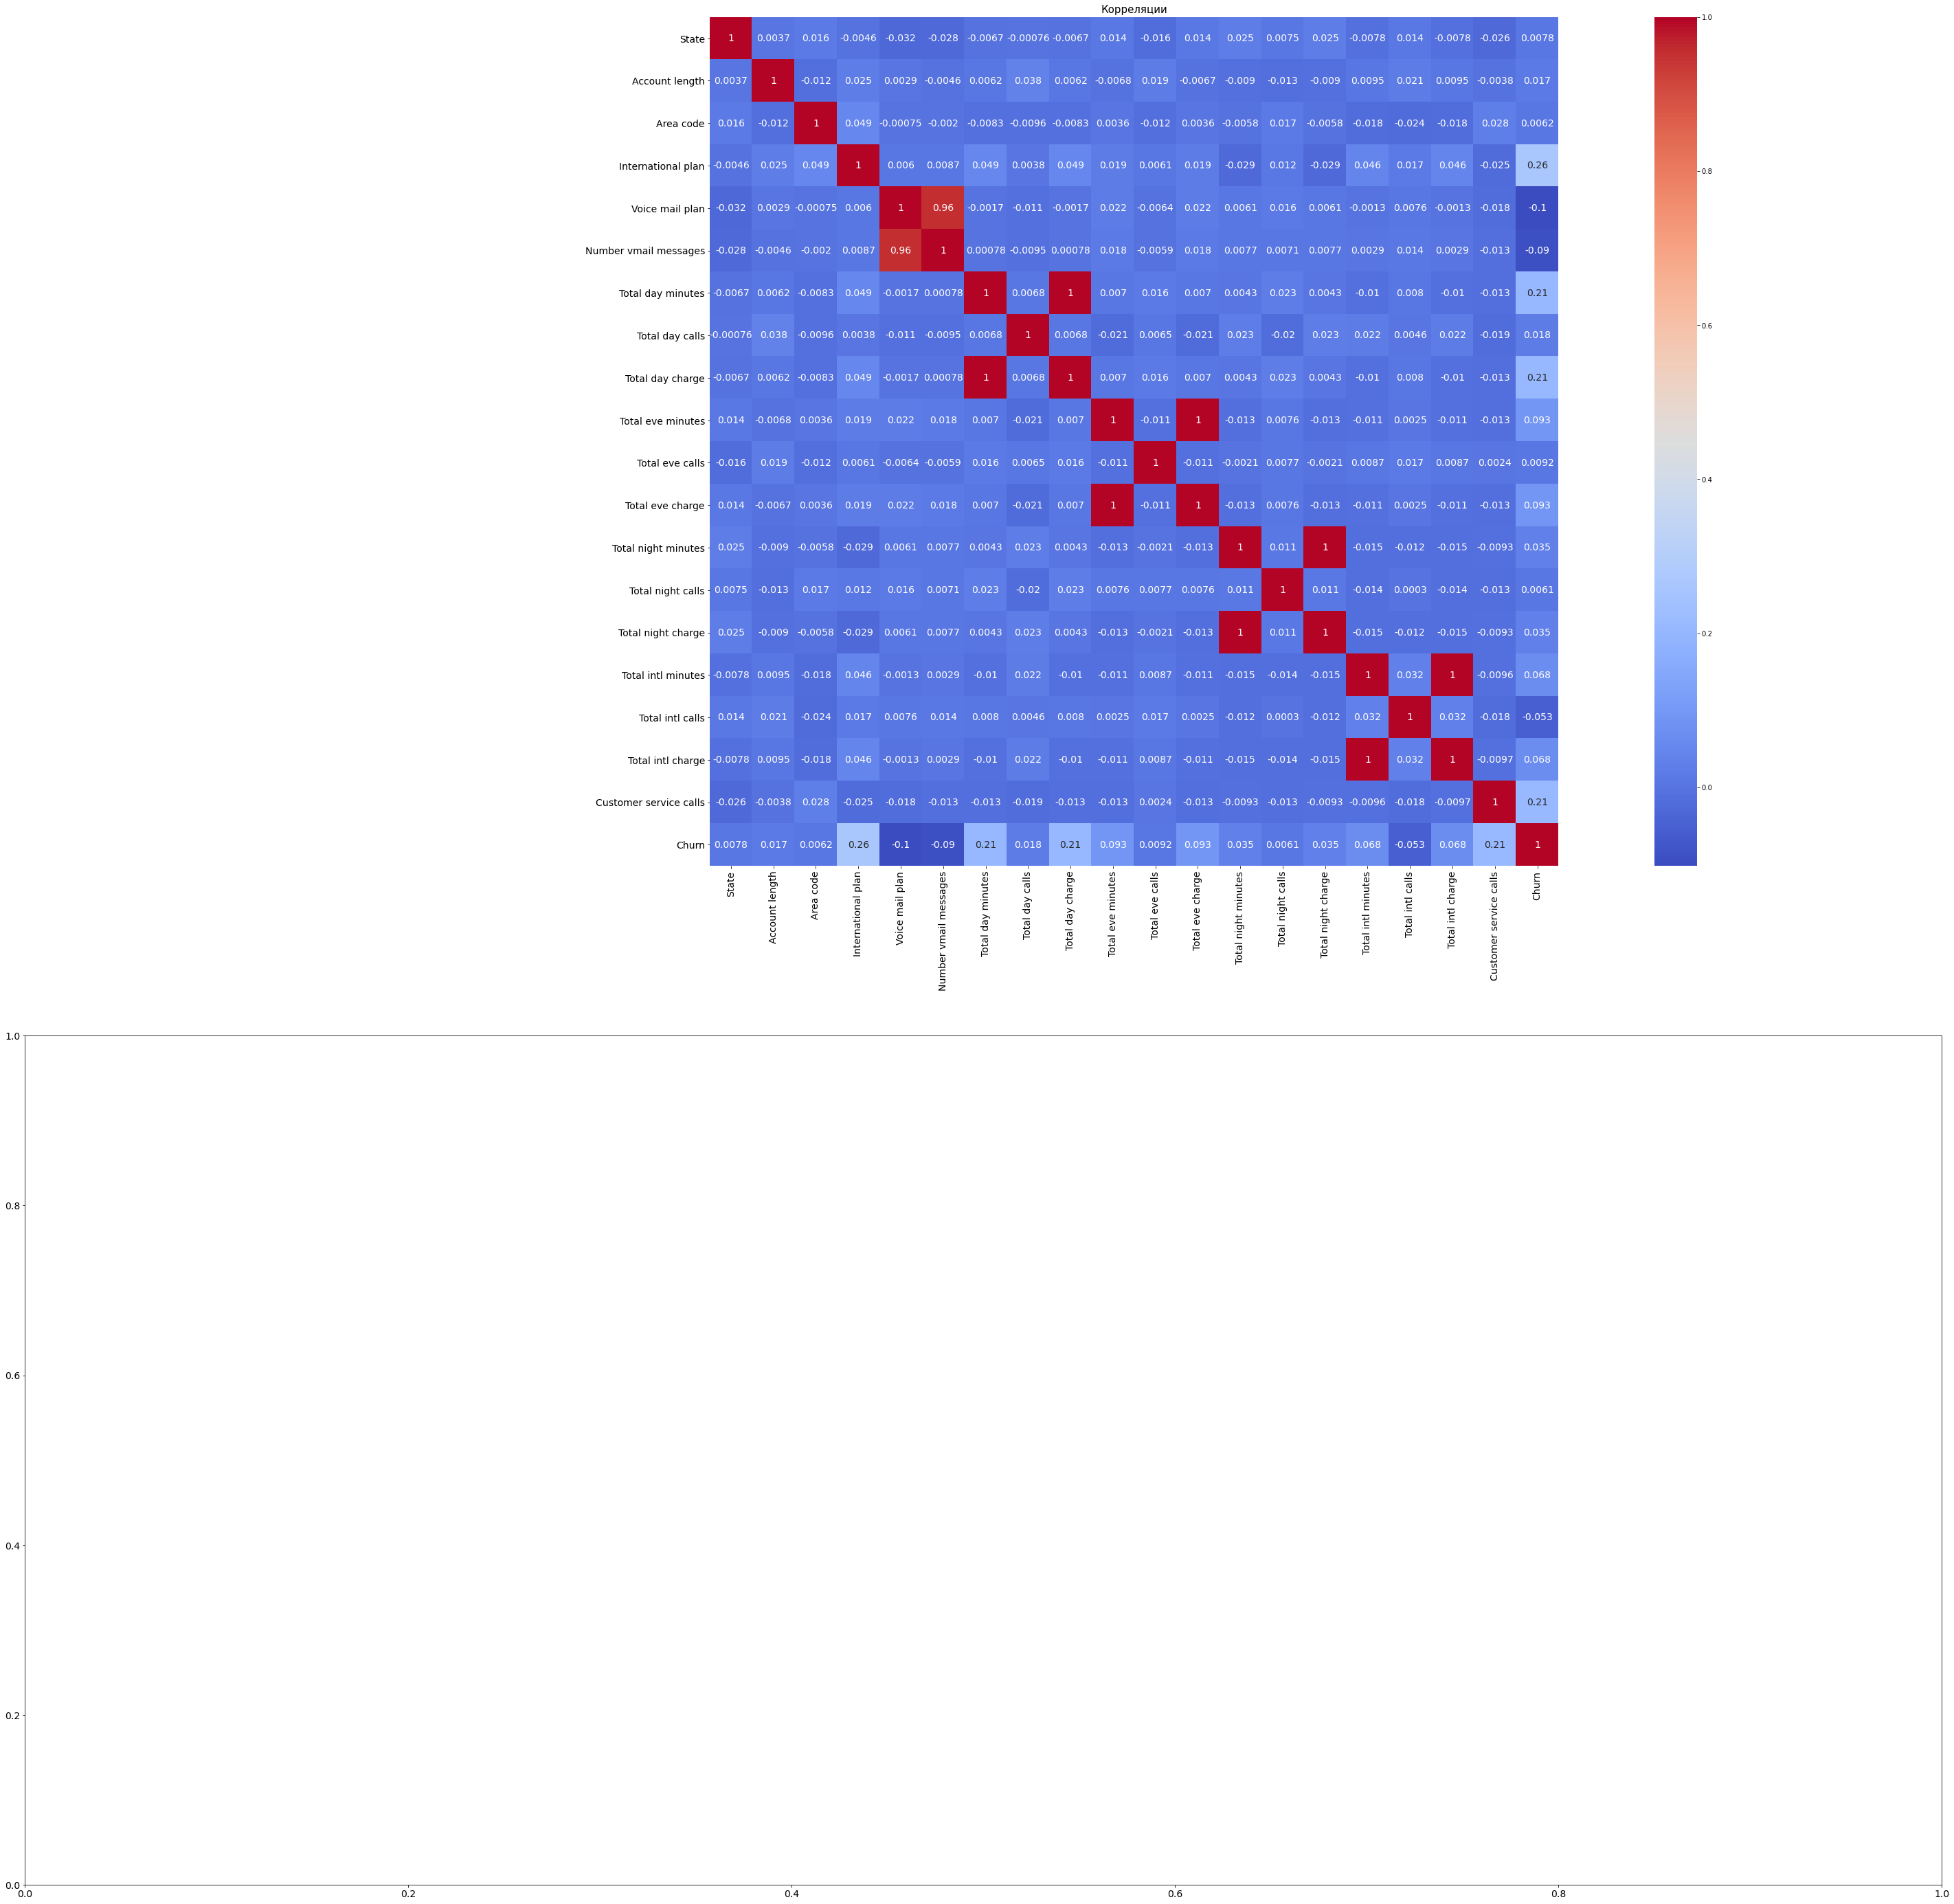

In [6]:
#можно посмотреть, как коррелируют столбики друг с другом
#производительность некоторых алгоритмов может ухудшиться, если две или более переменных тесно связаны между собой, что называется мультиколлинеарностью. 
import seaborn as sns
fig, axs = plt.subplots(nrows=2, figsize=(50, 50))
sns.heatmap((df).corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Корреляции', size=15)

In [7]:
#большое спасибо теме отсюда https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on/43104383#43104383

def remove_collinear_features(x, threshold):  
    # Не убираем корреляции между фичами и целью, потому что они наоборот помогают!
    y = x['Churn']
    x = x.drop(columns = ['Churn'])
    
    # Считаем матрицы корреляций
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            if val >= threshold:
                drop_cols.append(col.values[0])

    # Убрать одну из коррелирующих колонок в паре
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    
    # Вернуть результат обратно в датасет
    x['Churn'] = y
               
    return x

In [8]:
#сделаем копию датасета, чтобы не испортить основной
features = df.copy()
features = remove_collinear_features(features, 0.8);

In [9]:
#я проделала все то же самое с копией
non_numeric_features = ['State', 'International plan', 'Voice mail plan', 'Churn']

for feature in non_numeric_features:        
     features[feature] = LabelEncoder().fit_transform(features[feature])

Text(0.5, 1.0, 'Корреляции')

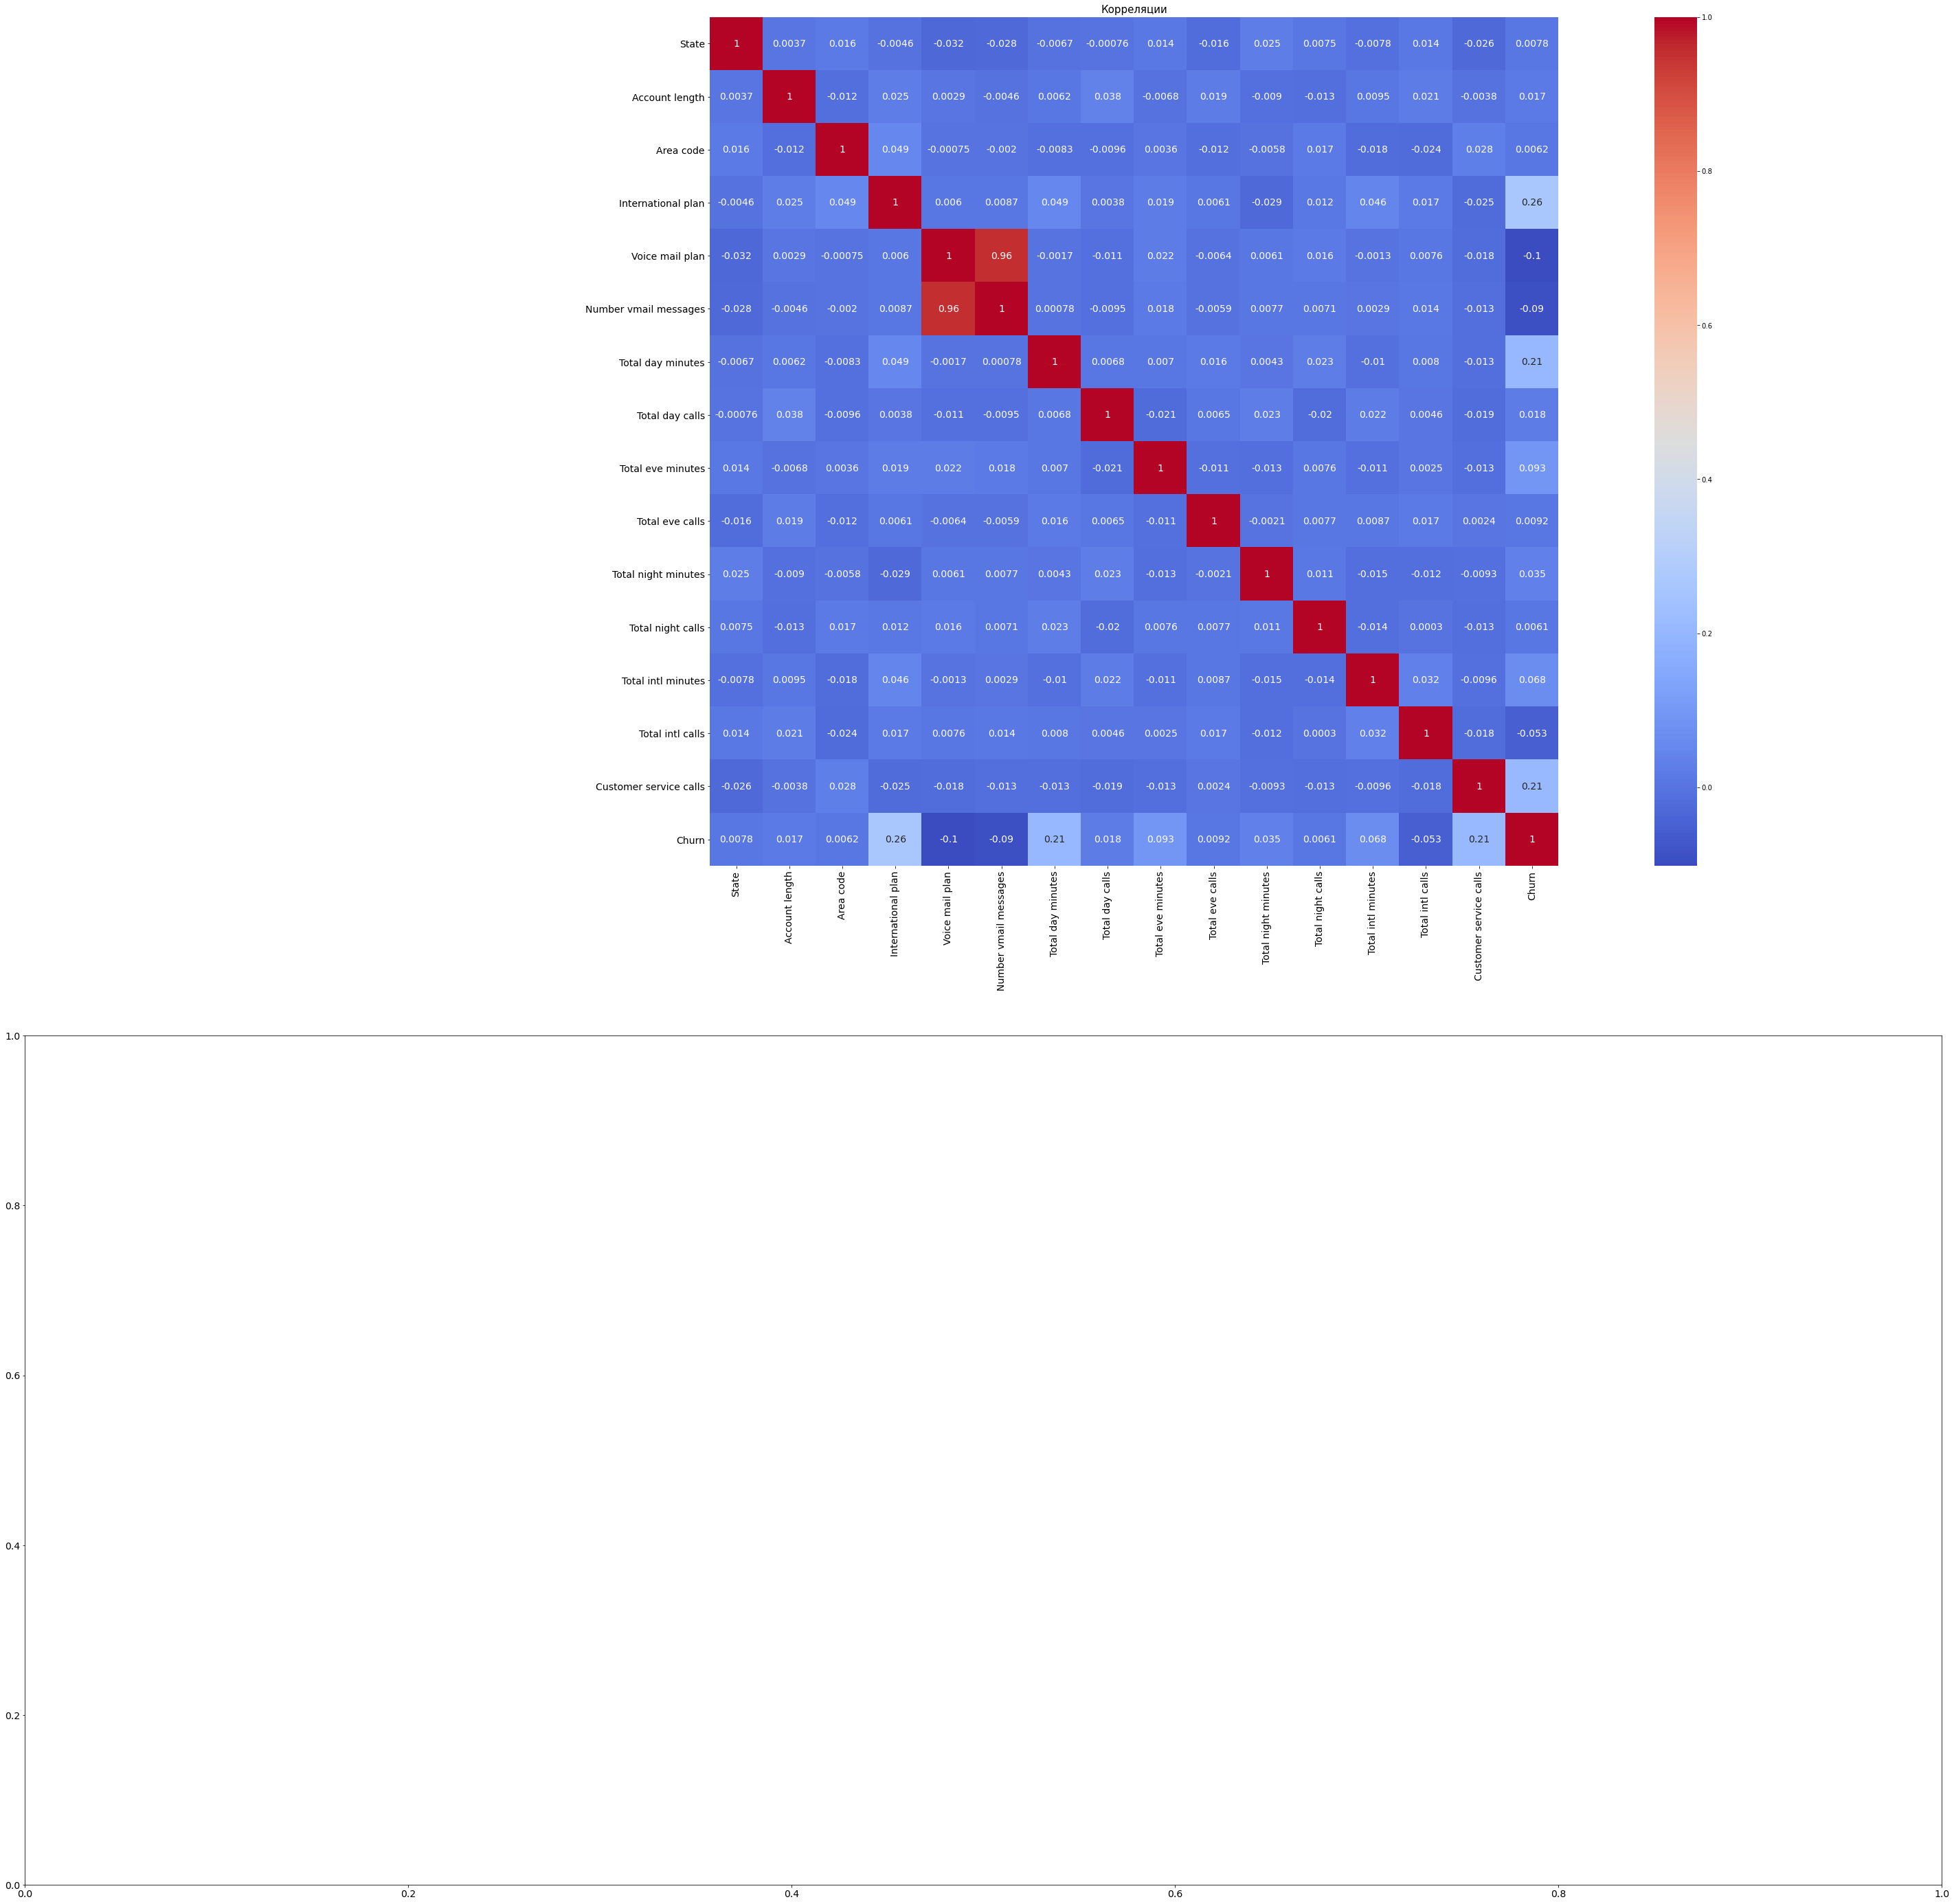

In [10]:
#можно еще раз построить карту и глянуть результат, он еще не идеален, но на данное решение хватит (не идеален, тк есть высокие корреляции еще)
import seaborn as sns
fig, axs = plt.subplots(nrows=2, figsize=(50, 50))
sns.heatmap((features).corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Корреляции', size=15)

In [11]:
features

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes,Total intl calls,Customer service calls,Churn
0,16,128,415,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0
1,35,107,415,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0
2,31,137,415,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0
3,35,84,408,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0
4,36,75,415,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,3,192,415,0,1,36,156.2,77,215.5,126,279.1,83,9.9,6,2,0
3329,49,68,415,0,0,0,231.1,57,153.4,55,191.3,123,9.6,4,3,0
3330,39,28,510,0,0,0,180.8,109,288.8,58,191.9,91,14.1,6,2,0
3331,6,184,510,1,0,0,213.8,105,159.6,84,139.2,137,5.0,10,2,0


In [12]:
#нужно поделить данные, можно просто сделать это с помощью loc, но я напихала колонки для наглядности тебе

X = features[{'State','Account length','Area code','International plan','Voice mail plan','Number vmail messages','Total day minutes','Total day calls','Total eve minutes','Total eve calls','Total night minutes','Total night calls','Total intl minutes','Total intl calls','Customer service calls'}]
y = features.Churn

In [13]:
#Нормализация данных
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

In [14]:
#попробую обучить модель на RandomForest`е
#впихну сюда GridSearch (это вопрос поиска по сетке)
#parameters = {
#    'n_estimators'      : [300, 400, 500],
#    'max_depth'         : [3, 4, 5, 6, 7],
#    'max_features': ['auto', 'sqrt', 'log2'],
#    'criterion' :['gini', 'entropy']
#}

#rf_model = RandomForestClassifier(random_state=42)

#clf = GridSearchCV(rf_model, parameters, cv=5)
#model = clf.fit(X_train, y_train)

In [24]:
#я не уверена, что грид выдал нормальные параметры, потому пихну кросс-валиадцию с 5 блоками
#я попробовала параметры, который выдал Грид, но оказалось, что можно и лучше, так что я поменяла их немного
#вообще, если играть с параметрами, возможно, можно и добиться еще выше результатов только за счет них

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

scores = []
leaderboard_model = RandomForestClassifier(criterion='gini',
                                           n_estimators=700,
                                           max_depth=18,
                                           min_samples_split=4,
                                           min_samples_leaf=1,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=42,
                                           n_jobs=-1,
                                           verbose=1) 
cv = KFold(n_splits=5)
for train_index, test_index in cv.split(X):

    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    leaderboard_model.fit(X_train, y_train)
    scores.append(leaderboard_model.score(X_test, y_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.7s 

In [25]:
#точность вышла 0,945
print(np.mean(scores))

0.9450932191561877


In [26]:
#тут я предсказываю на тестовом датасете, используя обученную модель
y_test_pred = leaderboard_model.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:    0.4s finished


In [27]:
#для наглядности можно построить датасет из разряда до\после, у меня тут что-то с ID-шниками, вообще их выкинуть можно нахрен, но я этим не занималась, тк тебе сейчас это не существенно
df2 = pd.DataFrame({'Churn': y_test, 'Predicted Churn': y_test_pred})
df2.head(20)

,Churn,Predicted Churn
2667,0,0
2668,0,0
2669,0,0
2670,0,0
2671,0,0
2672,1,1
2673,1,0
2674,0,0
2675,0,0
2676,0,0
